In [ ]:
from typing import List
import sys
sys.path.append('C:/Users/kupec/OneDrive/Desktop/neuroforest-main/neuroforest-master')
import numpy as np
import os
import time
from tqdm import tqdm
from main import dataloader, Coordinates, NeuroForestSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2022\trajectories_processed
Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2024\trajectories_processed
<class 'neuroforest.dataset.ImageLoader'>


In [13]:
COMPUTE_TEST = True
DISPLAY = True
COMPUTE = True
WRITE_TO_CSV = True

## Définition des fonctions & tests

### Fonctions pour extraction des points, calcul de features

In [14]:
def features_extraction(dataloader, session_type):
    samples = list(dataloader)
    data = []

    for sample in tqdm(samples, desc="Extracting coords & labels"):
        session = sample[session_type]  
        if session is not None:
            player_coords = np.array([c["coord"].to_vect() for c in session.player_coords])  
            player_coords = player_coords[:, [0, 2]]  # Keep only x and z

            if player_coords.shape[0] > 29999:
                player_coords = player_coords[:29999] 

            questionnaire_data = sample["questionnaire"]
            score_sum = None
            if questionnaire_data is not None:
                score_sum = sum(int(questionnaire_data[f"asrs{i}"]) for i in range(1, 19) if f"asrs{i}" in questionnaire_data)

            data.append({"id": sample.num_id, "label": score_sum, "trajectory": player_coords,})

    return pd.DataFrame(data)

In [15]:
def features_computing(df_trajectories):
    features_list = []
    
    for _, row in tqdm(df_trajectories.iterrows(), total=len(df_trajectories), desc="Computing features"):
        trajectory = np.array(row['trajectory'])
        player_id = row['id']
        
        v_instant, a_instant = [], []
        angle_instant, angular_speed_instant = [], []
        angular_acceleration_instant, curvature_instant = [], []
        
        for i in range(len(trajectory) - 1):
            delta_coords = trajectory[i + 1] - trajectory[i]
            v_instant.append(delta_coords * 25)
            
            if i > 0:
                delta_v = v_instant[-1] - v_instant[-2]
                a_instant.append(delta_v * 25)
                
                P1, P2, P3 = trajectory[i - 1], trajectory[i], trajectory[i + 1]
                vec_u, vec_v = P2 - P1, P3 - P2
                norm_u, norm_v = np.linalg.norm(vec_u), np.linalg.norm(vec_v)
                
                cos_theta = np.dot(vec_u, vec_v) / (norm_u * norm_v) if norm_u != 0 and norm_v != 0 else 1.0
                cos_theta = np.clip(cos_theta, -1.0, 1.0)
                angle_instant.append(np.arccos(cos_theta))
                
                if len(angle_instant) > 1:
                    angular_speed_instant.append((angle_instant[-1] - angle_instant[-2]) * 25)
                    angular_acceleration_instant.append((angular_speed_instant[-1] - angular_speed_instant[-2]) * 25)
                else:
                    angular_speed_instant.append(0.0)
                    angular_acceleration_instant.append(0.0)
                
                x0, y0 = P1
                x1, y1 = P2
                x2, y2 = P3
                numerator = (x1 - x0) * (y2 - y1) - (x2 - x1) * (y1 - y0)
                denominator = np.sqrt(((x1 - x0)**2 + (y1 - y0)**2) * ((x2 - x1)**2 + (y2 - y1)**2))
                curvature_instant.append(numerator / denominator if denominator != 0 else 0.0)
            else:
                a_instant.append(np.array([0.0, 0.0]))
                angle_instant.append(0.0)
                angular_speed_instant.append(0.0)
                angular_acceleration_instant.append(0.0)
                curvature_instant.append(0.0)
        
        features_list.append({
            'id': player_id,
            'speed_mean': np.mean(v_instant), 'speed_var': np.var(v_instant),
            'acceleration_mean': np.mean(a_instant), 'acceleration_var': np.var(a_instant),
            'angle_mean': np.mean(angle_instant), 'angle_var': np.var(angle_instant),
            'angular_speed_mean': np.mean(angular_speed_instant), 'angular_speed_var': np.var(angular_speed_instant),
            'angular_acceleration_mean': np.mean(angular_acceleration_instant), 'angular_acceleration_var': np.var(angular_acceleration_instant),
            'curvature_mean': np.mean(curvature_instant), 'curvature_var': np.var(curvature_instant)
        })
    
    return pd.DataFrame(features_list)


def features_over_time(df_trajectories):
    time_features_list = []
    
    for _, row in tqdm(df_trajectories.iterrows(), total=len(df_trajectories), desc="Computing time-dependent features"):
        trajectory = np.array(row['trajectory'])
        player_id = row['id']
        
        v_instant, a_instant = [], []
        angle_instant, angular_speed_instant = [], []
        angular_acceleration_instant, curvature_instant = [], []

        for i in range(len(trajectory) - 1):
            delta_coords = trajectory[i + 1] - trajectory[i]
            v = delta_coords * 25  # Vitesse
            v_instant.append(v)

            if i > 0:
                delta_v = v_instant[-1] - v_instant[-2]
                a = delta_v * 25  # Accélération
                a_instant.append(a)

                P1, P2, P3 = trajectory[i - 1], trajectory[i], trajectory[i + 1]
                vec_u, vec_v = P2 - P1, P3 - P2
                norm_u, norm_v = np.linalg.norm(vec_u), np.linalg.norm(vec_v)

                cos_theta = np.dot(vec_u, vec_v) / (norm_u * norm_v) if norm_u != 0 and norm_v != 0 else 1.0
                cos_theta = np.clip(cos_theta, -1.0, 1.0)
                angle = np.arccos(cos_theta)
                angle_instant.append(angle)

                if len(angle_instant) > 1:
                    angular_speed = (angle_instant[-1] - angle_instant[-2]) * 25
                    angular_speed_instant.append(angular_speed)
                    
                    angular_acceleration = (angular_speed_instant[-1] - angular_speed_instant[-2]) * 25
                    angular_acceleration_instant.append(angular_acceleration)
                else:
                    angular_speed_instant.append(0.0)
                    angular_acceleration_instant.append(0.0)

                x0, y0 = P1
                x1, y1 = P2
                x2, y2 = P3
                numerator = (x1 - x0) * (y2 - y1) - (x2 - x1) * (y1 - y0)
                denominator = np.sqrt(((x1 - x0)**2 + (y1 - y0)**2) * ((x2 - x1)**2 + (y2 - y1)**2))
                curvature = numerator / denominator if denominator != 0 else 0.0
                curvature_instant.append(curvature)
            else:
                a_instant.append(np.array([0.0, 0.0]))
                angle_instant.append(0.0)
                angular_speed_instant.append(0.0)
                angular_acceleration_instant.append(0.0)
                curvature_instant.append(0.0)
        
        time_features_list.append({
            'id': player_id,
            'speed_x': np.array(v_instant)[:, 0],
            'speed_z': np.array(v_instant)[:, 1],
            'speed': np.linalg.norm(np.array(v_instant), axis=1),
            'acceleration_x': np.array(a_instant)[:, 0],
            'acceleration_z': np.array(a_instant)[:, 1],
            'acceleration' : np.linalg.norm(np.array(a_instant), axis=1),
            'angle': np.array(angle_instant),
            'angular_speed': np.array(angular_speed_instant),
            'angular_acceleration': np.array(angular_acceleration_instant),
            'curvature': np.array(curvature_instant)
        })

    return pd.DataFrame(time_features_list)


### Exemple : creation d'un dataframe pour les trajectoires "uniformes" et d'un autre pour les features, puis merging

In [16]:
if COMPUTE_TEST:
    df_extraction_uniform = features_extraction(dataloader, "uniform")  # Contains IDs and trajectory
    df_time_features_uniform = features_over_time(df_extraction_uniform)# Contains IDs and features as series
    df_features_uniform = features_computing(df_extraction_uniform)     # Contains trajectory features
    #df_time_features_uniform = pd.merge(df_extraction_uniform, df_time_features_uniform, on='id')
    
if DISPLAY:
    df_time_features_uniform.head() 
    df_features_uniform.head()

Computing features: 100%|██████████| 39/39 [00:52<00:00,  1.33s/it]


In [17]:
df_time_features_uniform.head()

,id,speed_x,speed_z,speed,acceleration_x,acceleration_z,acceleration,angle,angular_speed,angular_acceleration,curvature
0,29,"[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5,"[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,35,"[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,19,"[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,20,"[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Affichage de la distribution d'ASRS

C:\Users\kupec\AppData\Local\Temp\ipykernel_12808\2902269443.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


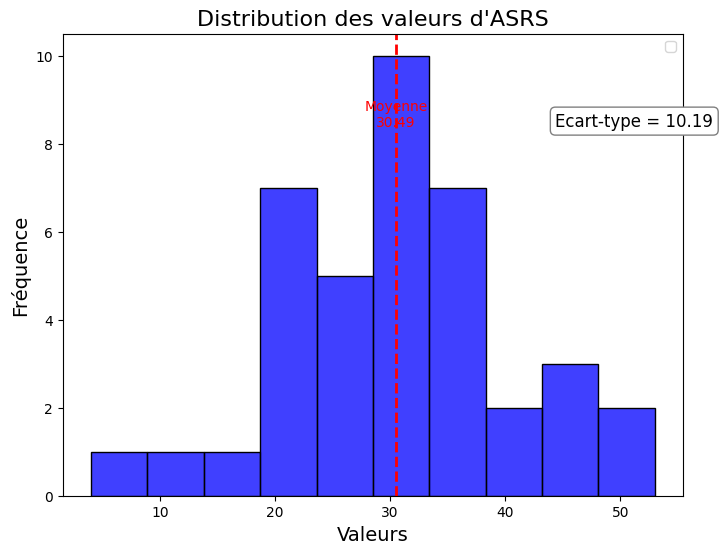

In [18]:
if DISPLAY:
    moyenne = np.mean(df_extraction_uniform["label"])
    stf = np.std(df_extraction_uniform["label"])

    # Tracer la distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(df_extraction_uniform["label"], kde=False, bins=10, color='blue')

    # Ajouter des annotations pour la moyenne et la variance
    plt.axvline(moyenne, color='red', linestyle='--', linewidth=2)
    plt.text(moyenne, plt.ylim()[1]*0.8, f"Moyenne\n{moyenne:.2f}", color="red", ha="center")

    plt.text(
        plt.xlim()[1]*0.8, plt.ylim()[1]*0.8,
        f"Ecart-type = {stf:.2f}",
        fontsize=12, color="black", bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray")
    )

    # Ajout des titres et des labels
    plt.title("Distribution des valeurs d'ASRS", fontsize=16)
    plt.xlabel('Valeurs', fontsize=14)
    plt.ylabel('Fréquence', fontsize=14)
    plt.legend()

    # Affichage du graphique
    plt.show()


### Calcul des autocorrélations pour les séries temporelles

In [19]:
def compute_autocorrelation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule l'autocorrélation pour chaque série temporelle de chaque colonne du DataFrame et ajoute les résultats
    en tant que nouvelles colonnes dédiées.

    Args:
        df (pd.DataFrame): Le DataFrame contenant des séries temporelles sous forme de tableaux numpy.

    Returns:
        pd.DataFrame: Un nouveau DataFrame avec les colonnes d'origine et leurs autocorrélations respectives.
    """
    autocorr_features = {}

    for col in tqdm(df.columns, desc="Computing autocorrelation"):
        if col == "id" :  # On ne calcule pas l'autocorrélation pour l'ID 
            autocorr_features[col] = df[col]
            continue
        if col == "label" : #On ne calculle pas l'autocorrélation pour le label
            continue

        autocorr_list = []
        for series in df[col]:  # Chaque case contient un array temporel
            series = np.array(series)
            if series.ndim > 1:  # Si la feature a plusieurs dimensions (ex: vitesse en x et z)
                series = np.linalg.norm(series, axis=1)  # On prend la norme du vecteur
            
            autocorr = np.correlate(series, series, mode='full')  # Autocorrélation complète
            autocorr = autocorr[autocorr.size // 2:]  # Garder la partie positive
            autocorr /= autocorr[0]  # Normalisation
            
            autocorr_list.append(autocorr)

        autocorr_features[f"autocorrelation_{col}"] = autocorr_list
    temp = pd.DataFrame(autocorr_features)

    return temp

Computing autocorrelation: 100%|██████████| 11/11 [01:58<00:00, 10.74s/it]


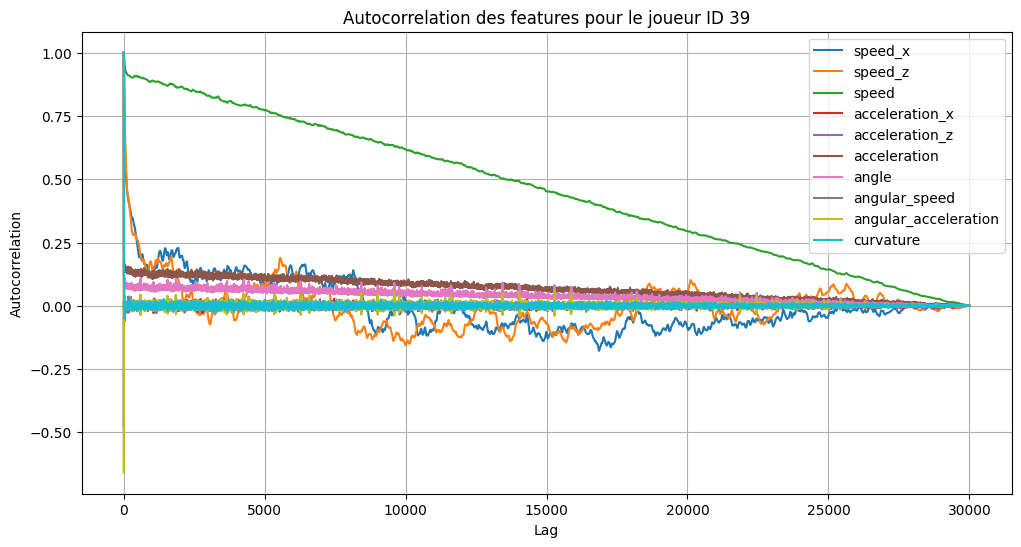

In [20]:
if COMPUTE_TEST:
    df_autocorrelations_uniform = compute_autocorrelation(df_time_features_uniform) # Contains autocorrelations
if DISPLAY:
    random_player = df_autocorrelations_uniform["id"].sample(1).values[0]
    player_data = df_autocorrelations_uniform[df_autocorrelations_uniform["id"] == random_player]
    autocorr_columns = [col for col in df_autocorrelations_uniform.columns if "autocorrelation" in col]
    
    plt.figure(figsize=(12, 6))

    # Tracer chaque autocorrélation
    for col in autocorr_columns:
        autocorr_values = player_data[col].values[0]  # Récupérer l'array d'autocorrélation
        plt.plot(autocorr_values, label=col.replace("autocorrelation_", ""))

    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title(f"Autocorrelation des features pour le joueur ID {random_player}")
    plt.legend()
    plt.grid()
    plt.show()


In [21]:
df_autocorrelations_uniform.head()


,id,autocorrelation_speed_x,autocorrelation_speed_z,autocorrelation_speed,autocorrelation_acceleration_x,autocorrelation_acceleration_z,autocorrelation_acceleration,autocorrelation_angle,autocorrelation_angular_speed,autocorrelation_angular_acceleration,autocorrelation_curvature
0,29,"[1.0, 0.9989511999387346, 0.9970517923080172, ...","[1.0, 0.9989337657233749, 0.9970732339316517, ...","[1.0, 0.9996712667274333, 0.9991720781406159, ...","[1.0, 0.40579218673462847, 0.4147633445538078,...","[1.0, 0.37265971901670053, 0.4205539730924519,...","[1.0, 0.44830609976669855, 0.5068363940656784,...","[1.0, 0.20254472892618827, 0.25111758070667284...","[1.0, -0.5304549068947909, 0.07017999949485647...","[1.0, -0.6962275738505691, 0.22715488147030297...","[1.0, 0.35493791076924874, 0.383793701048265, ..."
1,5,"[1.0, 0.9988339507761247, 0.996533796395482, 0...","[1.0, 0.9987155900559731, 0.9962286071546916, ...","[1.0, 0.9989282267273837, 0.996805164788119, 0...","[1.0, 0.5007178034247926, 0.5646288825430327, ...","[1.0, 0.48484084149306056, 0.5526919575035963,...","[1.0, 0.5147214076110987, 0.5924171623214581, ...","[1.0, 0.12044815624522798, 0.09534836086700235...","[1.0, -0.4857314863389554, -0.0093777636081499...","[1.0, -0.6603094930378729, 0.155786723582297, ...","[1.0, 0.36144338863099573, 0.26962416873921885..."
2,35,"[1.0, 0.9990096537182869, 0.9972509249729002, ...","[1.0, 0.9990034332542963, 0.9971376026551493, ...","[1.0, 0.9993810216517149, 0.9981891115268926, ...","[1.0, 0.3882473615068541, 0.45674883321344606,...","[1.0, 0.43628550437494906, 0.5392853461931059,...","[1.0, 0.5037563802214831, 0.5808570069966345, ...","[1.0, 0.42830584930753807, 0.4084277838838617,...","[1.0, -0.48261477277701803, 0.0560350814077292...","[1.0, -0.6816553645880066, 0.22571618001189814...","[1.0, 0.2657659448270887, 0.2984421770937956, ..."
3,19,"[1.0, 0.998242722366204, 0.9957541681727531, 0...","[1.0, 0.9972327496818938, 0.9960881616391449, ...","[1.0, 0.9990425353809738, 0.9985311429136842, ...","[1.0, 0.20898527236686862, 0.18979384394586227...","[1.0, -0.30017974039658585, 0.3749271691459374...","[1.0, 0.6127515533750642, 0.5561307832799978, ...","[1.0, 0.5180523137650134, 0.4315653320341015, ...","[1.0, -0.4102737914807653, -0.100384061095018,...","[1.0, -0.6098671464112371, 0.07377307503601586...","[1.0, -0.18563765339796098, 0.3340726300011656..."
4,20,"[1.0, 0.9974261380184417, 0.9922100593599933, ...","[1.0, 0.9972243377596407, 0.9916303047144348, ...","[1.0, 0.9982097792997285, 0.9945788243937849, ...","[1.0, 0.5135312294614982, 0.5567446124143656, ...","[1.0, 0.5078060539555606, 0.551491379058832, 0...","[1.0, 0.5750409845821124, 0.6491691143936457, ...","[1.0, 0.24014182940720852, 0.22385642402200331...","[1.0, -0.4892839176997332, 0.02235811770168834...","[1.0, -0.6717745116699024, 0.18225345650174485...","[1.0, 0.37899692962163123, 0.3328072124573829,..."


### Calcul de l'enveloppe convexe 

In [22]:
from scipy.spatial import ConvexHull

def compute_convex_hull_xz(coords: List[Coordinates]):
    """
    Calcule l'enveloppe convexe des coordonnées fournies en utilisant les dimensions x et z.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.

    Returns:
        hull (ConvexHull): L'objet ConvexHull représentant l'enveloppe convexe.
        hull_points (List[Coordinates]): Liste des coordonnées des sommets de l'enveloppe convexe.
    """
    # Convertir les coordonnées en array numpy (x et z uniquement)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z
    
    
    mask = (points[:, 0] > -170) & (points[:, 1] > -170)
    filtered_points = points[mask]
    filtered_coords = [c for i, c in enumerate(coords) if mask[i]]
    
    if len(filtered_points) < 3:
        raise ValueError("L'enveloppe convexe nécessite au moins trois points après exclusion.")
    
    # Calculer l'enveloppe convexe
    hull = ConvexHull(filtered_points)
    hull_points = [filtered_coords[i] for i in hull.vertices]  # Récupérer les coordonnées originales
    return hull, hull_points

def plot_convex_hull_xz(coords: List[Coordinates]):
    """
    Trace les positions et l'enveloppe convexe pour une liste de coordonnées en utilisant x et z.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.
    """
    hull, hull_points = compute_convex_hull_xz(coords)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z pour le tracé
    
    hull_points_array = np.array([p.to_vect()[[0, 2]] for p in hull_points])  # Convertir pour le tracé

    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], label="Points", alpha=0.6)
    plt.plot(np.append(hull_points_array[:, 0], hull_points_array[0, 0]),
             np.append(hull_points_array[:, 1], hull_points_array[0, 1]),
             'r-', label="Enveloppe convexe")
    plt.fill(hull_points_array[:, 0], hull_points_array[:, 1],
             'r', alpha=0.2, label="Zone Convexe")
    plt.legend()
    plt.title("Enveloppe Convexe (x, z)")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.show()

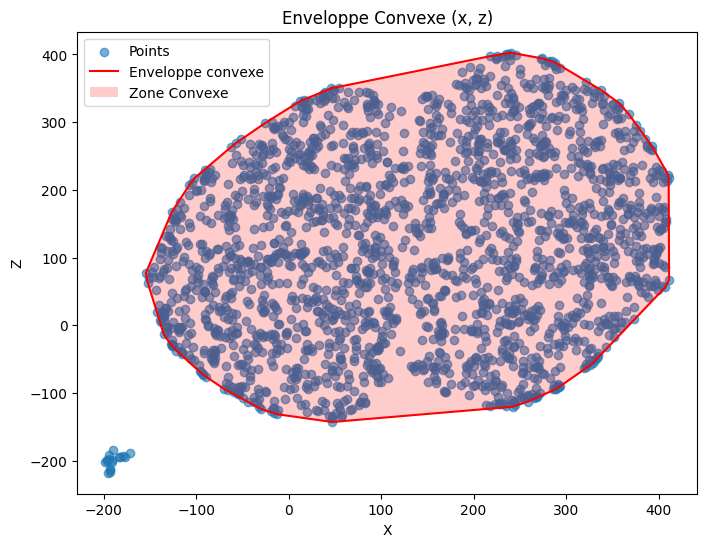

In [23]:
# On extrait les coordonnées des champignons stockées dans les sessions, on les concatène pour faire une 
# enveloppe convexe qui corresponde à peu près aux bords de l'île. 
# On retire manuellement les points de l'île.

if COMPUTE_TEST:    
    sample = next(iter(dataloader))
    session_uniform = sample.load_session("uniform")
    session_patchy = sample.load_session("patchy")
    coords_uniform = session_uniform.mushroom_coords
    coords_patchy = session_patchy.mushroom_coords
    coords = coords_uniform + coords_patchy
    hull, hull_points = compute_convex_hull_xz(coords)
if DISPLAY:
    plot_convex_hull_xz(coords)


### Calcul de la distance moyenne au bord

In [24]:
from scipy.spatial import distance

def average_distance_to_hull(df: pd.DataFrame, coords: List, metric: str) -> pd.DataFrame:
    """
    Calcule la distance moyenne des points d'une trajectoire aux bords de l'enveloppe convexe.

    Args:
        df (pd.DataFrame): DataFrame contenant les trajectoires et les ID des joueurs.
        coords (List): Liste des positions des champignons.
        metric (str): La métrique à utiliser pour calculer les distances.

    Returns:
        pd.DataFrame: DataFrame contenant les ID des joueurs et leur distance moyenne à l'enveloppe convexe.
    """
    # Calculer l'enveloppe convexe
    hull, _ = compute_convex_hull_xz(coords)
    hull_points = hull.points[hull.vertices]  # Points de l'enveloppe convexe

    # Calculer les distances moyennes pour chaque joueur
    distances = []
    for _, row in df.iterrows():
        player_id = row["id"]
        trajectory = np.array(row["trajectory"])  # Récupérer la trajectoire

        # Calculer les distances minimales au bord de la hull
        dist_matrix = distance.cdist(trajectory, hull_points, metric=metric)
        min_distances = np.min(dist_matrix, axis=1)  # Distance minimale pour chaque point
        avg_distance = np.mean(min_distances)  # Moyenne des distances
        
        distances.append({"id": player_id, "avg_distance_to_hull": avg_distance})

    return pd.DataFrame(distances)


In [25]:
if COMPUTE_TEST:
    df_distance_to_hull_uniform = average_distance_to_hull(df_extraction_uniform, coords, "euclidean")

In [26]:
df_distance_to_hull_uniform.head()

,id,avg_distance_to_hull
0,29,76.999854
1,5,75.235802
2,35,69.454739
3,19,79.473525
4,20,40.403058


### Calcul du diamètre d'une trajectoire

In [27]:
def compute_diameter(df_time: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule le diamètre d'une trajectoire (avec df_time), puis l'ajoute à df.
    
    Args:
        df_time (pd.DataFrame): DataFrame contenant une colonne "trajectory" et "id", d'où sera calculé le diamètre.
        
    Returns:
        pd.DataFrame: DataFrame df auquel sera ajoutée la colonne "diameter".
    """

    diameters = []
    for _,row in tqdm(df_time.iterrows(), desc = "Computing diameters", total = len(df_time['id'])):
        player_id = row["id"]
        trajectory = np.array(row["trajectory"])  # Récupérer la trajectoire
        diameter = np.max(distance.pdist(trajectory, metric="euclidean"))

        diameters.append({"id": player_id, "diameter": diameter})

    df_temp = pd.DataFrame(diameters)
    return df_temp
        

In [28]:
if COMPUTE_TEST:
    df_diameter_uniform = compute_diameter(df_extraction_uniform)

Computing diameters: 100%|██████████| 39/39 [04:34<00:00,  7.03s/it]


In [29]:
df_diameter_uniform.head()

,id,diameter
0,29,430.273369
1,5,284.733037
2,35,356.699322
3,19,619.332424
4,20,226.797991


### Délimitation de l'île en deux parties

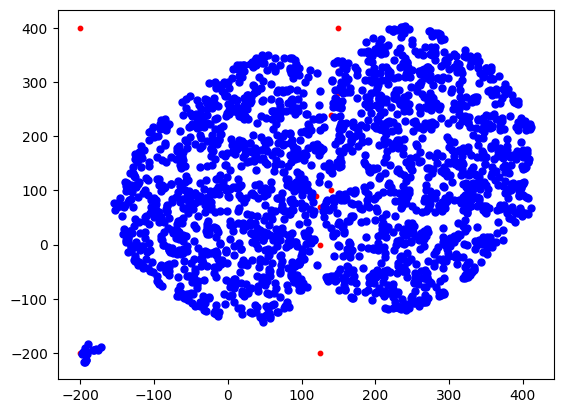

In [30]:
def compute_convex_hull_xz_with_polyline_limit(coords: List[Coordinates], polyline: List[Coordinates]):
    """
    Calcule l'enveloppe convexe des coordonnées fournies en utilisant les dimensions x et z,
    tout en excluant les points à droite de la pseudo-ligne définie par les points de la polyline.

    Args:
        coords (List[Coordinates]): Liste des positions sous forme d'objets Coordinates.
        polyline (List[Coordinates]): Liste des points qui définissent la pseudo-ligne de séparation.

    Returns:
        hull (ConvexHull): L'objet ConvexHull représentant l'enveloppe convexe.
        hull_points (List[Coordinates]): Liste des coordonnées des sommets de l'enveloppe convexe.
    """
    # Convertir les coordonnées en array numpy (x et z uniquement)
    points = np.array([c.to_vect()[[0, 2]] for c in coords])  # Utiliser x et z
    
    # Convertir les points de la polyline en numpy
    polyline_points = np.array([p.to_vect()[[0, 2]] for p in polyline])
    
    # Initialisation du masque pour filtrer les points
    mask = np.ones(len(points), dtype=bool)
    
    # Pour chaque segment de la polyline, déterminer de quel côté chaque point se trouve
    for i in range(len(polyline_points) - 1):
        p1 = polyline_points[i]
        p2 = polyline_points[i + 1]
        
        # Calculer le vecteur directeur du segment
        direction = p2 - p1
        
        # Calculer le vecteur normal au segment
        normal = np.array([direction[1], -direction[0]])  # Normal à la ligne (x, z)
        
        # Appliquer le produit scalaire pour déterminer si les points sont à gauche ou à droite du segment
        mask &= np.dot(points - p1, normal) >= 0  # Seulement à gauche ou sur la ligne
    
    # Filtrer les points
    filtered_points = points[mask]
    filtered_coords = [c for i, c in enumerate(coords) if mask[i]]
    
    if len(filtered_points) < 3:
        raise ValueError("L'enveloppe convexe nécessite au moins trois points après exclusion.")
    
    # Calculer l'enveloppe convexe
    hull = ConvexHull(filtered_points)
    hull_points = [filtered_coords[i] for i in hull.vertices]  # Récupérer les coordonnées originales
    return hull, hull_points

point1 = Coordinates(x=150, y=0, z=400)
point2 = Coordinates(x=150, y=0, z=320)
point3 = Coordinates(x=150, y=0, z=280)
point4 = Coordinates(x=140,y=0, z=240)
point5 = Coordinates(x=140,y=0, z=100)
point6 = Coordinates(x=120,y=0, z=90)
point7 = Coordinates(x=125,y=0, z=70)
point8 = Coordinates(x=125,y=0, z=0)
point9 = Coordinates(x=125,y=0, z=-200)
point10 = Coordinates(x=-200,y=0, z=-200)
point11 = Coordinates(x=-200,y=0, z=400)
river_points = [point1, point2, point3, point4, point5, point6, point7, point8, point9, point10, point11]

# 2 last point are made to define a closed polygon

if DISPLAY:
    for p in river_points:
        plt.scatter(p.to_vect()[0], p.to_vect()[2], color='red', s=10)

    for mushroom in coords:
        plt.plot(mushroom.to_vect()[0], mushroom.to_vect()[2], color = 'blue', marker = 'o', markersize = 5) 

    plt.show()


### Calcul du temps passé à droite de l'île

In [31]:
from shapely.geometry import Point, Polygon

def count_points_in_and_out(trajectory, river_points):
    """
    Compte le nombre de points d'une trajectoire à l'intérieur et à l'extérieur de la polyligne.
    
    Arguments:
    - trajectory: Liste de points représentant la trajectoire.
    - river_points: Liste des points qui définissent la polyligne de séparation (la rivière).
    
    Retour:
    - Compte des points à l'intérieur et à l'extérieur de la polyligne.
    """
    # Créer le polygone de la rivière à partir de la polyligne
    river_coords = [(p.to_vect()[0], p.to_vect()[2]) for p in river_points]
    polygon = Polygon(river_coords)

    inside_count = 0
    outside_count = 0

    # Vérifier pour chaque point de la trajectoire
    for p in trajectory:
        point = Point(p[0], p[1])  # Créer un objet Point
        if polygon.contains(point):
            inside_count += 1
        else:
            outside_count += 1

    return inside_count, outside_count

def plot_trajectory_with_river(trajectory, river_points, inside_count, outside_count):
    """
    Trace la trajectoire et la polyligne de la rivière avec le nombre de points à l'intérieur et à l'extérieur de la ligne.
    """
    # Tracer la polyligne de la rivière
    river_x = [p.to_vect()[0] for p in river_points[:-2]]
    river_z = [p.to_vect()[2] for p in river_points[:-2]]
    plt.plot(river_x, river_z, color='red', label="Rivière", lw=2)

    # Tracer la trajectoire
    trajectory_x = [p[0] for p in trajectory]
    trajectory_z = [p[1] for p in trajectory]
    plt.plot(trajectory_x, trajectory_z, color='blue', label="Trajectoire")

    # Affichage des résultats
    plt.title(f"Trajectoire - Points à gauche: {inside_count}, Points à droite: {outside_count}")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.legend()
    plt.show()
    
def compute_time_ratio(df_time: pd.DataFrame, river_points = river_points) -> pd.DataFrame:
    """
    Calcule le ratio de temps passé à droite par rapport au temps passé à gauche de la rivière.
    
    Arguments:
    - df_time (pd.DataFrame): DataFrame contenant les trajectoires et les IDs des joueurs.
    - river_points: Liste des points définissant la rivière (polyligne de séparation).
    
    Retour:
    - pd.DataFrame: DataFrame contenant l'ID et le ratio de temps passé à droite/gauche.
    """

    ratios = []
    for _,row in tqdm(df_time.iterrows(), desc = "Computing ratios", total = len(df_time['id'])):
        player_id = row["id"]
        trajectory = np.array(row["trajectory"])  # Récupérer la trajectoire
        inside_count, outside_count = count_points_in_and_out(trajectory, river_points)
        ratio = outside_count / (inside_count+outside_count)
        ratios.append({"id": player_id, "time_ratio_spent_on_right_side": ratio})

    df_temp = pd.DataFrame(ratios)
    return df_temp


In [32]:
if COMPUTE_TEST:
    df_ratio_uniform = compute_time_ratio(df_extraction_uniform)

Computing ratios: 100%|██████████| 39/39 [01:31<00:00,  2.33s/it]


In [33]:
df_ratio_uniform.head()

,id,time_ratio_spent_on_right_side
0,29,0.058269
1,5,0.000000
2,35,0.000000
3,19,0.492450
4,20,0.000000


### Calcul de la longueur de trajectoire

In [34]:
def compute_length(df_time: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule la longueur de trajectoire totale.
    
    Arguments:
    - df (pd.DataFrame): DataFrame principal contenant les IDs des joueurs.
    - df_time (pd.DataFrame): DataFrame contenant les trajectoires et les IDs des joueurs.
    
    Retour:
    - pd.DataFrame: DataFrame contenant l'ID et la longueur de la trajectoire.
    """

    longueurs = []
    for _,row in tqdm(df_time.iterrows(), desc = "Computing lengths", total = len(df_time['id'])):
        player_id = row["id"]
        trajectory = np.array(row["trajectory"])  # Récupérer la trajectoire
        distance = np.linalg.norm(trajectory[1:] - trajectory[:-1], axis=1)
        longueur = np.sum(distance)
        longueurs.append({"id": player_id, "length": longueur})

    df_temp = pd.DataFrame(longueurs)
    return df_temp


In [35]:
if COMPUTE_TEST:
    df_lengths_uniform = compute_length(df_extraction_uniform)

Computing lengths: 100%|██████████| 39/39 [00:00<00:00, 1001.17it/s]


In [36]:
df_lengths_uniform.head()

,id,length
0,29,2258.610813
1,5,1121.288708
2,35,1713.245133
3,19,2120.177612
4,20,895.782950


### Calcul du nombre de champignons ramassés

In [37]:
def mushroom_count(dataloader, session_type):
    samples = list(dataloader)
    mushroom_data = []
    
    for sample in tqdm(samples, desc="Extracting mushrooms"):
        session = sample[session_type]
        mushroom_data.append({'id': sample.num_id, 'mushrooms': len(session.gathered_mushrooms) if session else 0})
    
    return pd.DataFrame(mushroom_data)

In [38]:
if COMPUTE_TEST:
    uniform_mushrooms = mushroom_count(dataloader, "uniform")
uniform_mushrooms.head()

Extracting mushrooms: 100%|██████████| 39/39 [00:21<00:00,  1.81it/s]


,id,mushrooms
0,29,76
1,5,44
2,35,76
3,19,76
4,20,44


C:\Users\kupec\AppData\Local\Temp\ipykernel_12808\2683186468.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


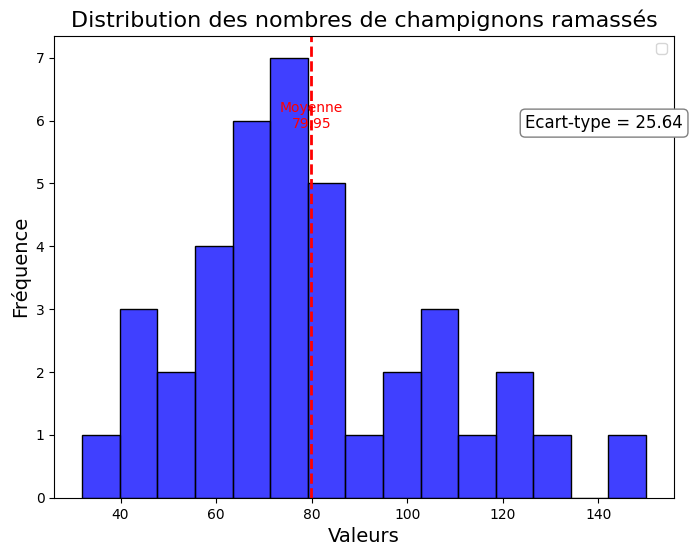

In [39]:
if DISPLAY:
    moyenne = np.mean(uniform_mushrooms["mushrooms"])
    stf = np.std(uniform_mushrooms["mushrooms"])

    # Tracer la distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(uniform_mushrooms["mushrooms"], kde=False, bins=15, color='blue')

    # Ajouter des annotations pour la moyenne et la variance
    plt.axvline(moyenne, color='red', linestyle='--', linewidth=2)
    plt.text(moyenne, plt.ylim()[1]*0.8, f"Moyenne\n{moyenne:.2f}", color="red", ha="center")

    plt.text(
        plt.xlim()[1]*0.8, plt.ylim()[1]*0.8,
        f"Ecart-type = {stf:.2f}",
        fontsize=12, color="black", bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray")
    )

    # Ajout des titres et des labels
    plt.title("Distribution des nombres de champignons ramassés", fontsize=16)
    plt.xlabel('Valeurs', fontsize=14)
    plt.ylabel('Fréquence', fontsize=14)
    plt.legend()

    # Affichage du graphique
    plt.show()


## Pipeline d'écriture CSV (uniform & patchy)

### Points de l'environnement

In [40]:
##########################################
##########################################
    
# Island points
    
sample = next(iter(dataloader))
session_uniform = sample.load_session("uniform")
session_patchy = sample.load_session("patchy")
coords_uniform = session_uniform.mushroom_coords
coords_patchy = session_patchy.mushroom_coords
coords = coords_uniform + coords_patchy
    
# River points
    
point1 = Coordinates(x=150, y=0, z=400)
point2 = Coordinates(x=150, y=0, z=320)
point3 = Coordinates(x=150, y=0, z=280)
point4 = Coordinates(x=140,y=0, z=240)
point5 = Coordinates(x=140,y=0, z=100)
point6 = Coordinates(x=120,y=0, z=90)
point7 = Coordinates(x=125,y=0, z=70)
point8 = Coordinates(x=125,y=0, z=0)
point9 = Coordinates(x=125,y=0, z=-200)
point10 = Coordinates(x=-200,y=0, z=-200)
point11 = Coordinates(x=-200,y=0, z=400)
river_points = [point1, point2, point3, point4, point5, point6, point7, point8, point9, point10, point11]
##########################################
##########################################

### DataFrames

On calcule deux dataframes par session : 
- L'un contient les valeurs de type "séries" (trajectoires, features bas niveau au cours du temps, ainsi que les autocorrélations)
- L'autre contient les valeurs "globales", excluant les séries.

Les deux dataframes contiennent les labels et sont indexés par les ID définis dans les questionnaire CSV

In [41]:
if COMPUTE:
    
    # Uniform session
    df_extraction_uniform = features_extraction(dataloader, "uniform")  
    df_time_features_uniform = features_over_time(df_extraction_uniform)
    df_features_uniform = features_computing(df_extraction_uniform)

    df_autocorrelations_uniform = compute_autocorrelation(df_time_features_uniform)
    df_distance_to_hull_uniform = average_distance_to_hull(df_extraction_uniform, coords, "euclidean")
    df_diameter_uniform = compute_diameter(df_extraction_uniform)
    df_ratio_uniform = compute_time_ratio(df_extraction_uniform)
    df_lengths_uniform = compute_length(df_extraction_uniform)
    uniform_mushrooms = mushroom_count(dataloader, "uniform")
    
    df_uniform_series = pd.merge(df_extraction_uniform, df_time_features_uniform, on='id')
    df_uniform_series = pd.merge(df_uniform_series, df_autocorrelations_uniform, on='id')
    
    df_uniform = pd.merge(df_features_uniform, df_distance_to_hull_uniform, on='id')
    df_uniform = pd.merge(df_uniform, df_diameter_uniform, on='id')
    df_uniform = pd.merge(df_uniform, df_ratio_uniform, on='id')
    df_uniform = pd.merge(df_uniform, df_lengths_uniform, on='id')
    df_uniform = pd.merge(df_uniform, uniform_mushrooms, on='id')
    df_uniform = pd.merge(df_uniform, df_extraction_uniform[['id', 'label']], on='id')
    


Extracting mushrooms: 100%|██████████| 39/39 [00:21<00:00,  1.79it/s]


In [42]:
df_uniform.head()

,id,speed_mean,speed_var,acceleration_mean,acceleration_var,angle_mean,angle_var,angular_speed_mean,angular_speed_var,angular_acceleration_mean,angular_acceleration_var,curvature_mean,curvature_var,avg_distance_to_hull,diameter,time_ratio_spent_on_right_side,length,mushrooms,label
0,29,0.067417,1.858162,0.000058,2.463325,0.012713,0.004487,3.897282e-07,4.634315,3.390394e-06,8865.762208,-0.000067,0.001883,76.999854,430.273369,0.058269,2258.610813,76,36
1,5,-0.089810,0.865743,-0.001156,1.297012,0.003719,0.000880,1.210126e-07,0.983112,-3.367901e-18,1825.799859,0.000213,0.000225,75.235802,284.733037,0.000000,1121.288708,44,26
2,35,0.062854,1.371262,0.000019,1.707227,0.008065,0.000723,8.530782e-19,0.562876,5.773545e-18,1043.160614,0.000115,0.000725,69.454739,356.699322,0.000000,1713.245133,76,34
3,19,0.135153,1.767697,0.001481,5.042894,0.018093,0.007931,2.315467e-06,4.975146,-5.420254e-04,8770.387841,-0.000775,0.003728,79.473525,619.332424,0.492450,2120.177612,76,49
4,20,0.078541,0.708313,0.000019,2.384824,0.010495,0.004458,-2.230309e-18,4.338947,1.130458e-16,8077.404100,-0.000663,0.002284,40.403058,226.797991,0.000000,895.782950,44,19


In [43]:
df_uniform_series.head()

,id,label,trajectory,speed_x,speed_z,speed,acceleration_x,acceleration_z,acceleration,angle,...,autocorrelation_speed_x,autocorrelation_speed_z,autocorrelation_speed,autocorrelation_acceleration_x,autocorrelation_acceleration_z,autocorrelation_acceleration,autocorrelation_angle,autocorrelation_angular_speed,autocorrelation_angular_acceleration,autocorrelation_curvature
0,29,36,"[[-121.65299987792969, 195.31199645996094], [-...","[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[1.0, 0.9989511999387346, 0.9970517923080172, ...","[1.0, 0.9989337657233749, 0.9970732339316517, ...","[1.0, 0.9996712667274333, 0.9991720781406159, ...","[1.0, 0.40579218673462847, 0.4147633445538078,...","[1.0, 0.37265971901670053, 0.4205539730924519,...","[1.0, 0.44830609976669855, 0.5068363940656784,...","[1.0, 0.20254472892618827, 0.25111758070667284...","[1.0, -0.5304549068947909, 0.07017999949485647...","[1.0, -0.6962275738505691, 0.22715488147030297...","[1.0, 0.35493791076924874, 0.383793701048265, ..."
1,5,26,"[[-121.65299987792969, 195.31199645996094], [-...","[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[1.0, 0.9988339507761247, 0.996533796395482, 0...","[1.0, 0.9987155900559731, 0.9962286071546916, ...","[1.0, 0.9989282267273837, 0.996805164788119, 0...","[1.0, 0.5007178034247926, 0.5646288825430327, ...","[1.0, 0.48484084149306056, 0.5526919575035963,...","[1.0, 0.5147214076110987, 0.5924171623214581, ...","[1.0, 0.12044815624522798, 0.09534836086700235...","[1.0, -0.4857314863389554, -0.0093777636081499...","[1.0, -0.6603094930378729, 0.155786723582297, ...","[1.0, 0.36144338863099573, 0.26962416873921885..."
2,35,34,"[[-121.65299987792969, 195.31199645996094], [-...","[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[1.0, 0.9990096537182869, 0.9972509249729002, ...","[1.0, 0.9990034332542963, 0.9971376026551493, ...","[1.0, 0.9993810216517149, 0.9981891115268926, ...","[1.0, 0.3882473615068541, 0.45674883321344606,...","[1.0, 0.43628550437494906, 0.5392853461931059,...","[1.0, 0.5037563802214831, 0.5808570069966345, ...","[1.0, 0.42830584930753807, 0.4084277838838617,...","[1.0, -0.48261477277701803, 0.0560350814077292...","[1.0, -0.6816553645880066, 0.22571618001189814...","[1.0, 0.2657659448270887, 0.2984421770937956, ..."
3,19,49,"[[-121.65299987792969, 195.31199645996094], [-...","[-0.1384735107421875, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.092315673828125, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[0.16642444775815685, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.4618377685546875, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -2.307891845703125, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 4.160611193953922, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[1.0, 0.998242722366204, 0.9957541681727531, 0...","[1.0, 0.9972327496818938, 0.9960881616391449, ...","[1.0, 0.9990425353809738, 0.9985311429136842, ...","[1.0, 0.20898527236686862, 0.18979384394586227...","[1.0, -0.30017974039658585, 0.3749271691459374...","[1.0, 0.6127515533750642, 0.5561307832799978, ...","[1.0, 0.5180523137650134, 0.4315653320341015

In [44]:
if COMPUTE:
    
    # Patchy session
    df_extraction_patchy = features_extraction(dataloader, "patchy")  
    df_time_features_patchy = features_over_time(df_extraction_patchy)
    df_features_patchy = features_computing(df_extraction_patchy)
    
    df_autocorrelations_patchy = compute_autocorrelation(df_time_features_patchy)
    df_distance_to_hull_patchy = average_distance_to_hull(df_extraction_patchy, coords, "euclidean")
    df_diameter_patchy = compute_diameter(df_extraction_patchy)
    df_ratio_patchy = compute_time_ratio(df_extraction_patchy)
    df_lengths_patchy = compute_length(df_extraction_patchy)
    patchy_mushrooms = mushroom_count(dataloader, "patchy")
    
    df_patchy_series = pd.merge(df_extraction_patchy, df_time_features_patchy, on='id')
    df_patchy_series = pd.merge(df_patchy_series, df_autocorrelations_patchy, on='id')
    
    df_patchy = pd.merge(df_features_patchy, df_distance_to_hull_patchy, on='id')
    df_patchy = pd.merge(df_patchy, df_diameter_patchy, on='id')
    df_patchy = pd.merge(df_patchy, df_ratio_patchy, on='id')
    df_patchy = pd.merge(df_patchy, df_lengths_patchy, on='id')
    df_patchy = pd.merge(df_patchy, patchy_mushrooms, on='id')
    df_patchy = pd.merge(df_patchy, df_extraction_patchy[['id', 'label']], on='id')

Extracting mushrooms: 100%|██████████| 39/39 [00:26<00:00,  1.46it/s]


In [45]:
if WRITE_TO_CSV:
    df_uniform.to_csv('results/uniform_features.csv', index=False, sep=";")
    df_uniform_series.to_csv('results/uniform_series.csv', index=False, sep=";")
    df_patchy.to_csv('results/patchy_features.csv', index=False, sep=";")
    df_patchy_series.to_csv('results/patchy_series.csv', index=False, sep=";")